<a href="https://colab.research.google.com/github/Jayavathsan/DeepLearning/blob/main/PyTorch/AutoEncoders/tiedWeights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autoencoder with tied weights


In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-1-c3fe6799ddb5>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
%matplotlib notebook

In [3]:
%matplotlib inline

# An aside on Linear vs. Parameter classes

In [4]:
# create an input and weights matrix
x  = torch.rand(10,50)
W1 = nn.Parameter(torch.randn(128,50))

# W1
print(W1)
print('\n\n')

# size and the size of its transpose
# print(W1.shape)
# print(W1.t().shape)
# print('\n\n')

# # compute an output
# y = x@W1
# print(y.shape)

Parameter containing:
tensor([[-0.5372, -0.9428, -0.1729,  ...,  0.2869, -0.1598, -1.3963],
        [ 0.8974,  1.9654,  0.8178,  ..., -0.4206,  0.8300, -1.1788],
        [ 0.1319, -1.8405,  0.1572,  ..., -1.9192, -1.1230, -1.5721],
        ...,
        [-0.5914, -2.9344,  1.1192,  ...,  0.1178, -0.9427,  2.3008],
        [-0.1193,  0.1760,  1.1735,  ...,  0.0423, -0.5714, -0.8020],
        [ 0.8096,  0.1189, -1.0281,  ...,  0.7489,  1.1576,  0.8147]],
       requires_grad=True)





In [5]:
# Linear method
W2 = nn.Linear(128,50)

# W2
print(W2)
print('\n\n')

# # size and the size of its transpose
# print(W2.shape)
# print(W2.weight.t().shape)
# print('\n\n')

# # compute an output
# y = x @ (W2.weight)
# print(y.shape)

Linear(in_features=128, out_features=50, bias=True)





In [6]:

print(W1.shape)
print(W2.weight.shape)


# (size of W -> [outputs,inputs], but nn.Linear expects [inputs,outputs])

torch.Size([128, 50])
torch.Size([50, 128])


In [7]:
# attributes of the class Linear
dir(nn.Linear)

# docstring for Linear.forward
# ??nn.Linear.forward()
# ??nn.Linear.__init__() # inputs vs. how weight is created

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__constants__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_call_impl',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_maybe_warn_non_full_backward_hook',
 '_named_members',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_version',
 'add_module',
 'apply',
 'bfloat16',
 'buffers',
 'call_super_init',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'get_buffer',
 'get_

# Import and process the data

In [8]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# label not necessary
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Create the DL model

In [9]:
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)

      ### encoder layer
      self.enc = nn.Parameter(torch.randn(50,128))
      # self.enc = nn.Linear(128,50) # not used! left here for comparison

      ### latent layer (not used!)
      #self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      # "normal" forward prop in first stage
      x = F.relu( self.input(x) )

      # a Parameter type is not a Linear type, so we implement the multiplication directly
      x = x.t() # need to transpose the input matrix due to multisample input matrices
      x = F.relu( self.enc@x )

      # same for the decoding layer but reversed
      x = F.relu( self.enc.t()@x )
      x = x.t() # and then transpose it back

      # "normal" final stage
      y = torch.sigmoid( self.dec(x) )
      return y

  # create the model instance
  net = aenet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [10]:
# test the model with a bit of data
net,lossfun,optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


# Create a function that trains the model

In [11]:
def function2trainTheModel():

  # number of epochs
  numepochs = 10000

  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # select a random set of images
    randomidx = np.random.choice(dataT.shape[0],size=32)
    X = dataT[randomidx,:]

    # forward pass and loss
    yHat = net(X)
    loss = lossfun(yHat,X)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # losses in this epoch
    losses[epochi] = loss.item()
  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0162


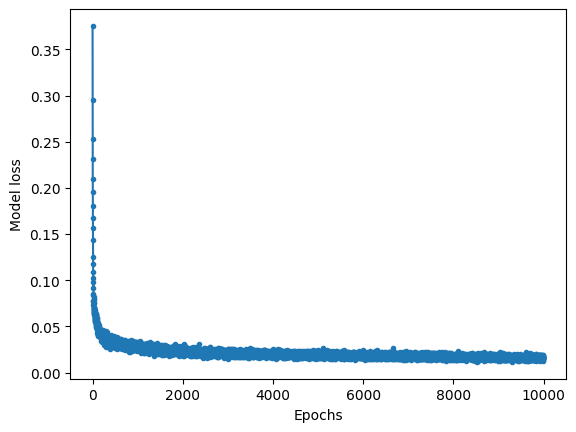

In [12]:
# train the model
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

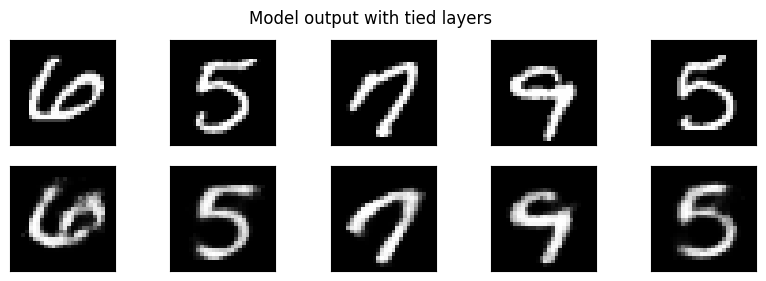

In [13]:
# Visualization of inputs and outputs
X = dataT[:5,:]
yHat = net(X)


# model performance
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(yHat[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.suptitle('Model output with tied layers')
plt.show()

# Add noise to see a use case of an autoencoder

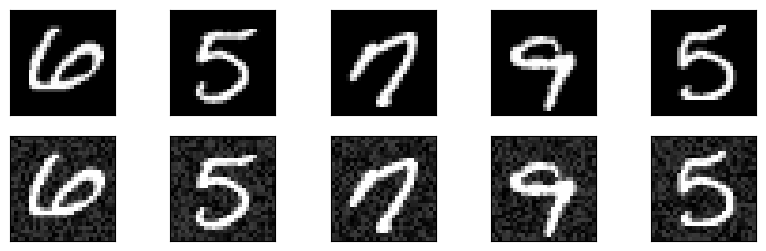

In [14]:
# grab a small set of images
X = dataT[:10,:]

# add noise
Xnoise = X + torch.rand_like(X)/4

# clip at 1
Xnoise[Xnoise>1] = 1


# show the noisy images
fig,axs = plt.subplots(2,5,figsize=(10,3))

for i in range(5):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])

plt.show()

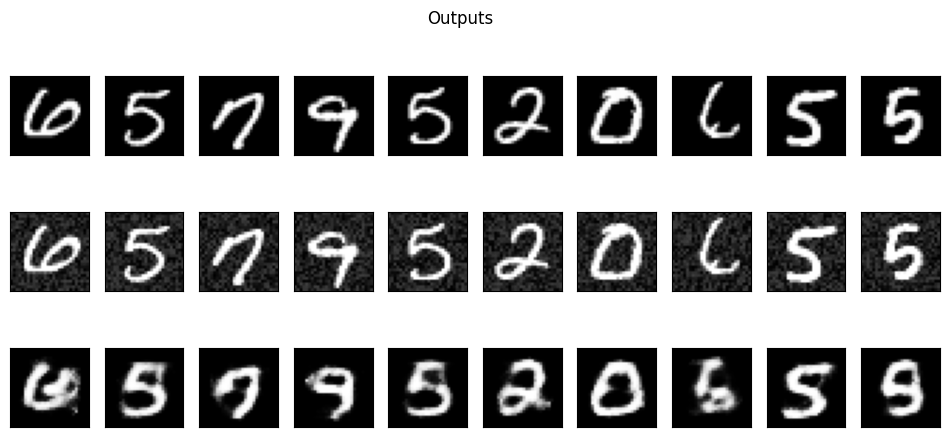

In [16]:
# run through the model
Y = net(Xnoise)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(12,5))

for i in range(10):
  axs[0,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(Xnoise[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(Y[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.suptitle('Outputs')
plt.show()